In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [53]:
data_path = 'survey_results.csv'
data_raw_df= pd.read_csv(data_path)
data_raw_df.head(1)

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [54]:
data_raw_df.shape

(50, 13)

In [55]:
data_raw_df.columns

Index(['Which age group do you belong to?', 'What is your gender?',
       'Which category do you currently belong to?',
       'Which of the following best describes you?',
       'Which of these factors are important to you when deciding which car to purchase?',
       'How likely are you to opt for customised vehicle if there were no extra charges? ',
       'Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ',
       'Which of the following interior components would you choose to customise (texture, layout, size, etc)? ',
       'How much are you willing to spend on car customisation if surcharges are applicable?',
       'Are you interested in designing your own components to personalise your car? ',
       'How much are you willing to pay for the personalised design? ',
       'Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)',
       'Please give us any desi

In [56]:
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

In [57]:
#General description of our data set

data_raw_df.describe()

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
count,50,50,50,50,49,50,49,50,50,50,50,50,17
unique,4,3,3,3,37,3,23,16,5,3,4,2,17
top,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels,Dashboard,500-1000,Only with professional help,500-1000,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
freq,41,32,36,38,5,37,8,11,19,26,21,33,1


In [58]:
# checks which column has missing values (True) and which have none (False)

data_raw_df.isnull().any()

Which age group do you belong to?                                                                                         False
What is your gender?                                                                                                      False
Which category do you currently belong to?                                                                                False
Which of the following best describes you?                                                                                False
Which of these factors are important to you when deciding which car to purchase?                                           True
How likely are you to opt for customised vehicle if there were no extra charges?                                          False
Which of the following exterior components would you choose to customise (texture, layout, size, etc)?                     True
Which of the following interior components would you choose to customise (texture, layout, size, etc)?  

In [59]:
# proportion of missing values 

data_raw_df.isnull().sum() / data_raw_df.shape[0]

Which age group do you belong to?                                                                                         0.00
What is your gender?                                                                                                      0.00
Which category do you currently belong to?                                                                                0.00
Which of the following best describes you?                                                                                0.00
Which of these factors are important to you when deciding which car to purchase?                                          0.02
How likely are you to opt for customised vehicle if there were no extra charges?                                          0.00
Which of the following exterior components would you choose to customise (texture, layout, size, etc)?                    0.02
Which of the following interior components would you choose to customise (texture, layout, size, etc)?         

In [60]:
for column_name in data_raw_df.columns:
    print(column_name)
    print(data_raw_df[column_name].unique())
    print("")

Which age group do you belong to?
['20-30' '51-60' '41-50' '31-40']

What is your gender?
['Male' 'Female' 'Prefer not to say']

Which category do you currently belong to?
['Do not own a car, but planning to purchase in future'
 'Own more than one car' 'Own a car']

Which of the following best describes you?
['Single' 'Married with children' 'Married with no children']

Which of these factors are important to you when deciding which car to purchase?
['Price;Functionality;Size;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Sustainability/environment considerations'
 'Aesthetics;Functionality;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainability/environment considerations'
 'Price;Brand name;Aesthetics;Technological features;Functionality'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size'
 'Price;Technological features;Functionality'
 'Price;Br

In [61]:
# number of instances of each unique categories

for column_name in data_raw_df.columns:
    print(data_raw_df[column_name].value_counts())
    print("")

Which age group do you belong to?
20-30    41
31-40     4
41-50     3
51-60     2
Name: count, dtype: int64

What is your gender?
Male                 32
Female               17
Prefer not to say     1
Name: count, dtype: int64

Which category do you currently belong to?
Do not own a car, but planning to purchase in future    36
Own a car                                               13
Own more than one car                                    1
Name: count, dtype: int64

Which of the following best describes you?
Single                      38
Married with children        6
Married with no children     6
Name: count, dtype: int64

Which of these factors are important to you when deciding which car to purchase?
Price;Brand name;Aesthetics;Technological features;Functionality;Size                                                                   5
Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainability/environment considerations    3
Pric

In [62]:
# proportion of each unique instance in column

for column_name in data_raw_df.columns:
        if data_raw_df[column_name].dtype == 'object':
                print(data_raw_df[column_name].value_counts() / data_raw_df[column_name].notnull().sum())
        print("")

Which age group do you belong to?
20-30    0.82
31-40    0.08
41-50    0.06
51-60    0.04
Name: count, dtype: float64

What is your gender?
Male                 0.64
Female               0.34
Prefer not to say    0.02
Name: count, dtype: float64

Which category do you currently belong to?
Do not own a car, but planning to purchase in future    0.72
Own a car                                               0.26
Own more than one car                                   0.02
Name: count, dtype: float64

Which of the following best describes you?
Single                      0.76
Married with children       0.12
Married with no children    0.12
Name: count, dtype: float64

Which of these factors are important to you when deciding which car to purchase?
Price;Brand name;Aesthetics;Technological features;Functionality;Size                                                                   0.102041
Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainabi

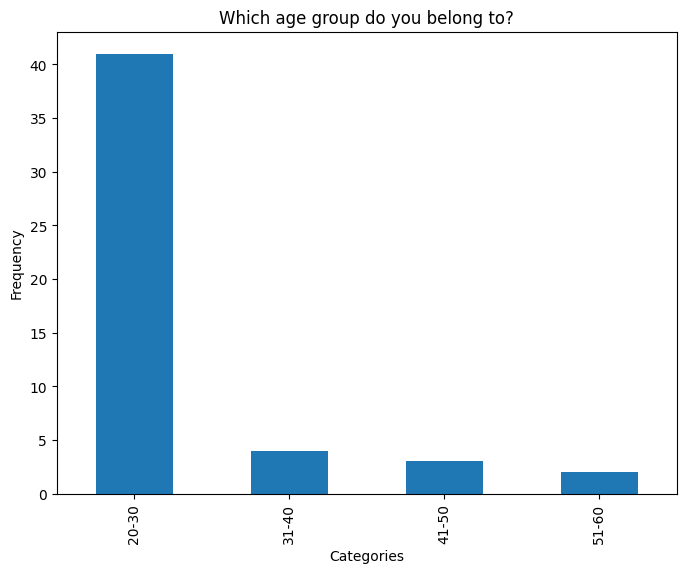

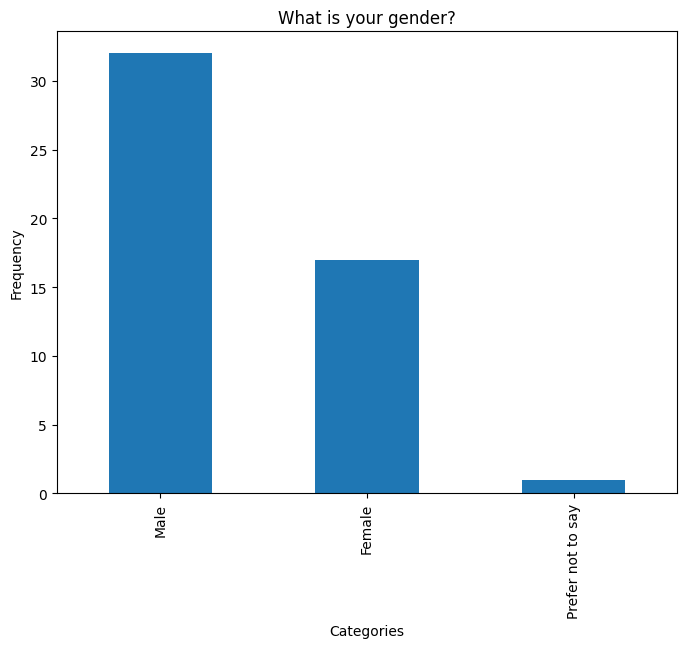

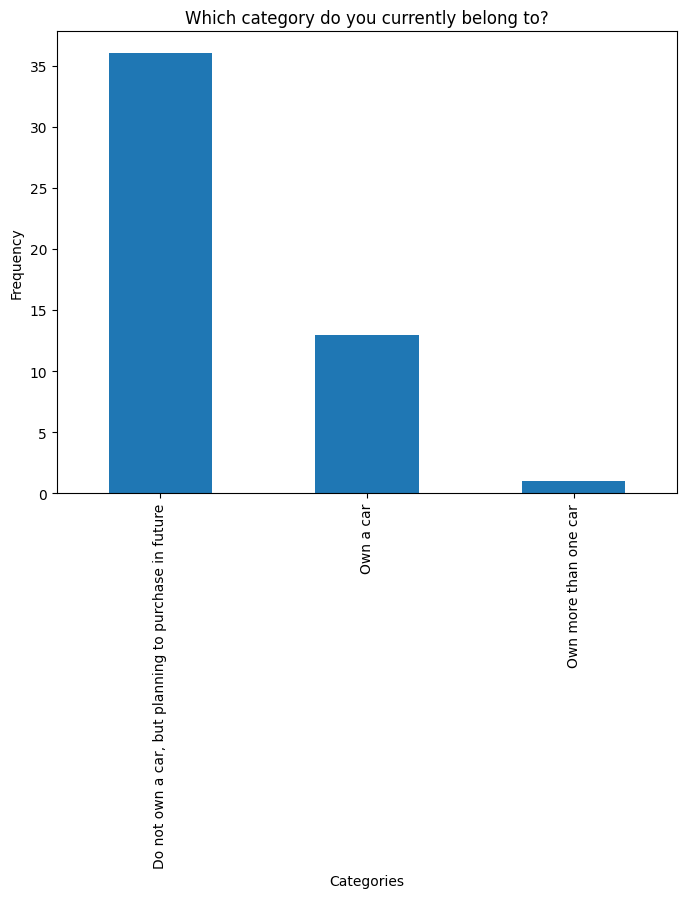

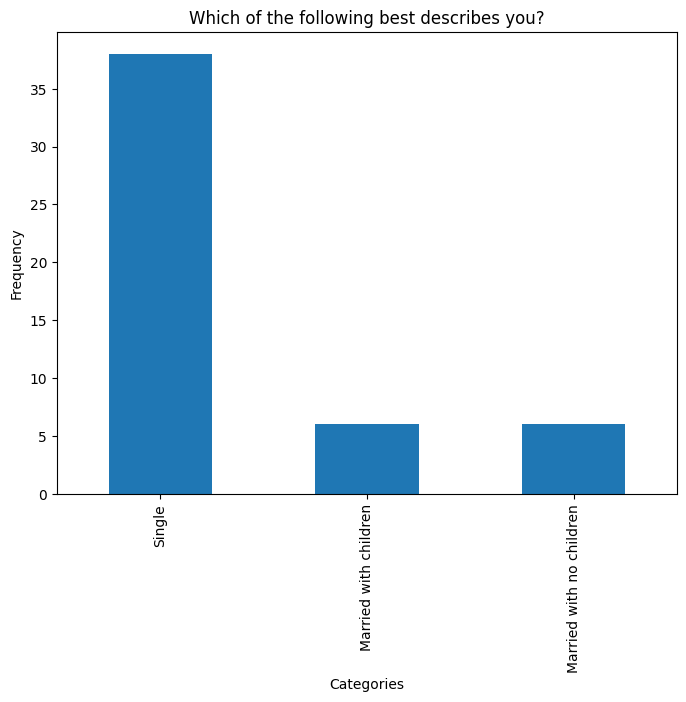

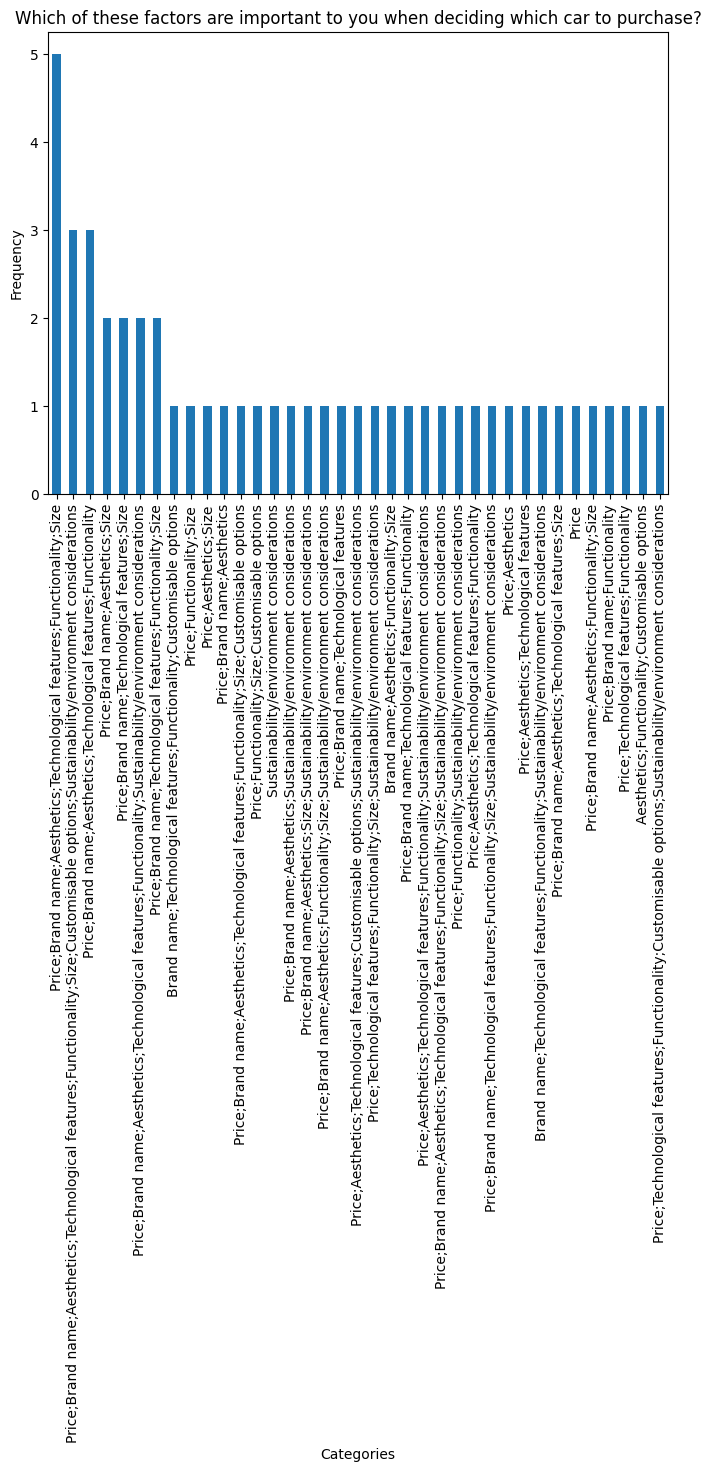

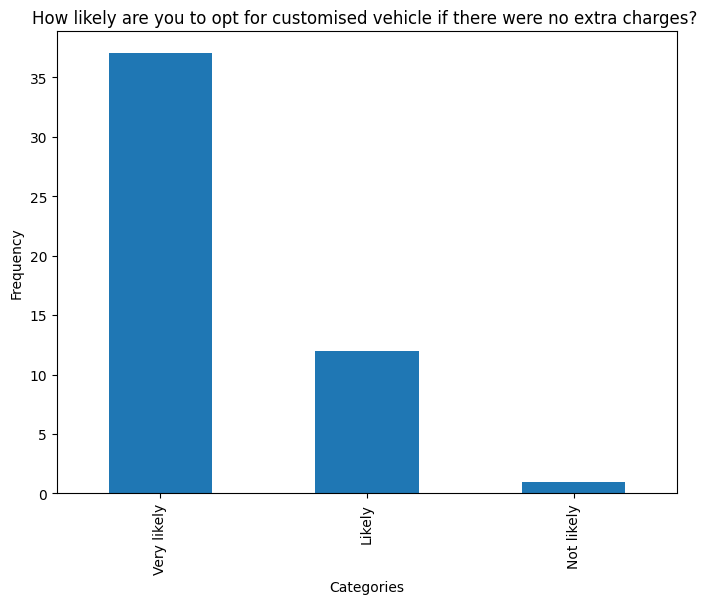

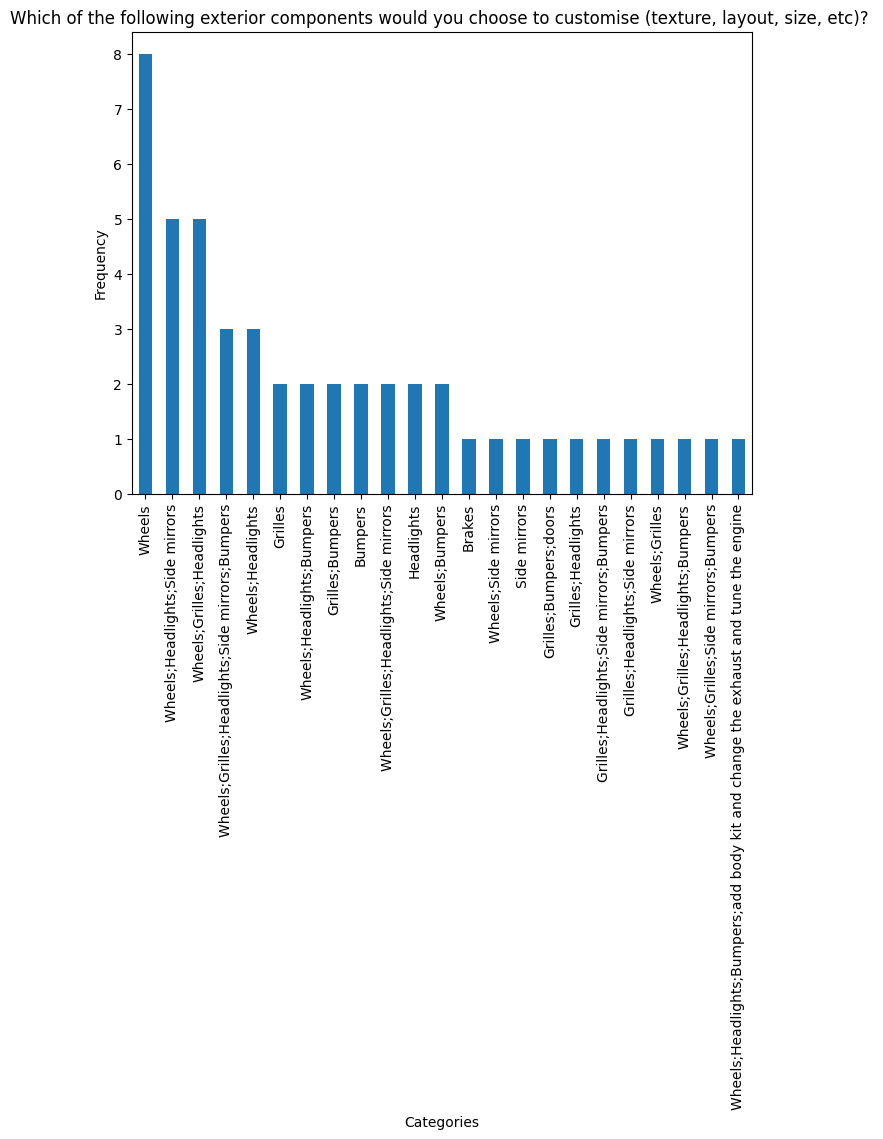

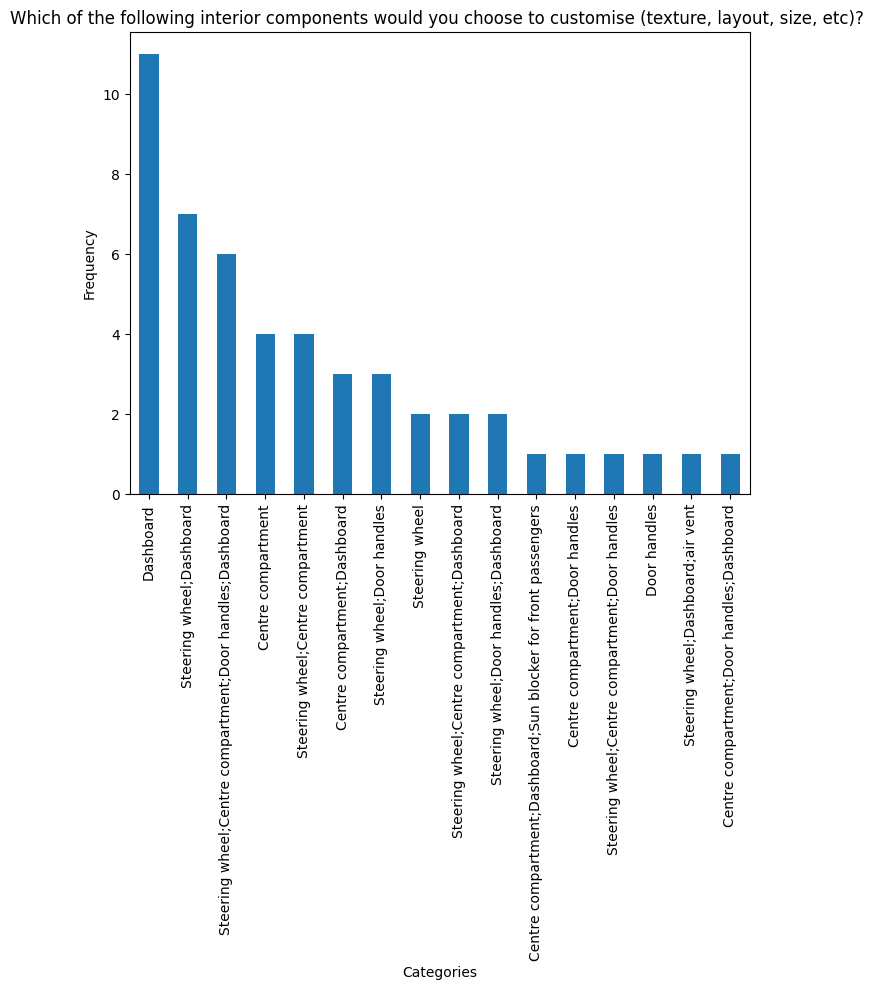

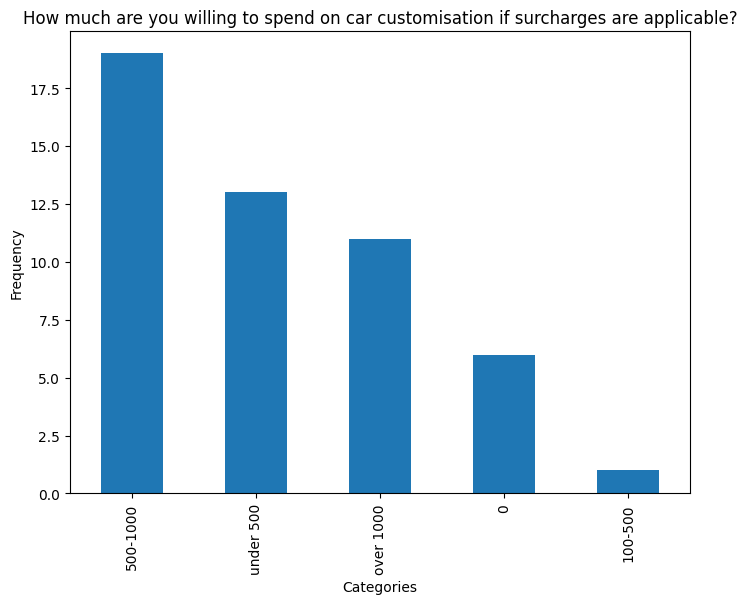

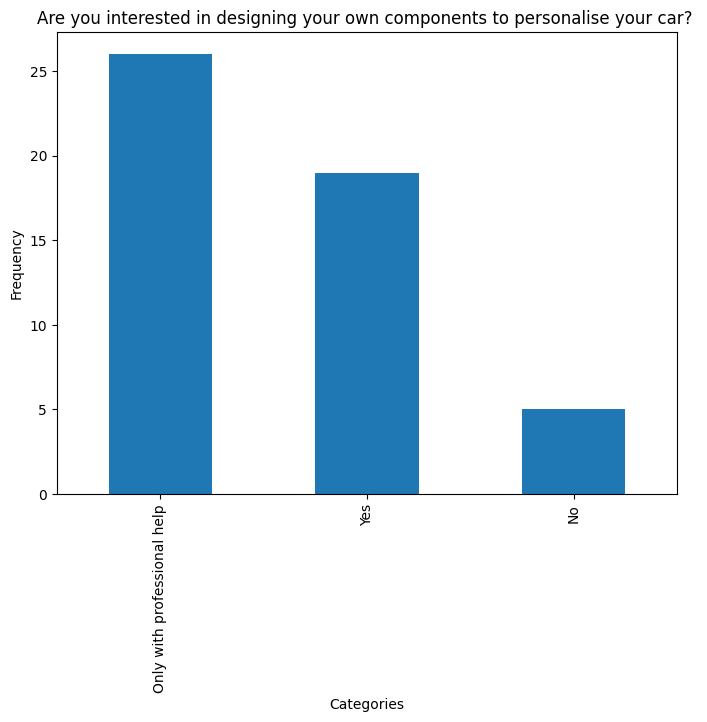

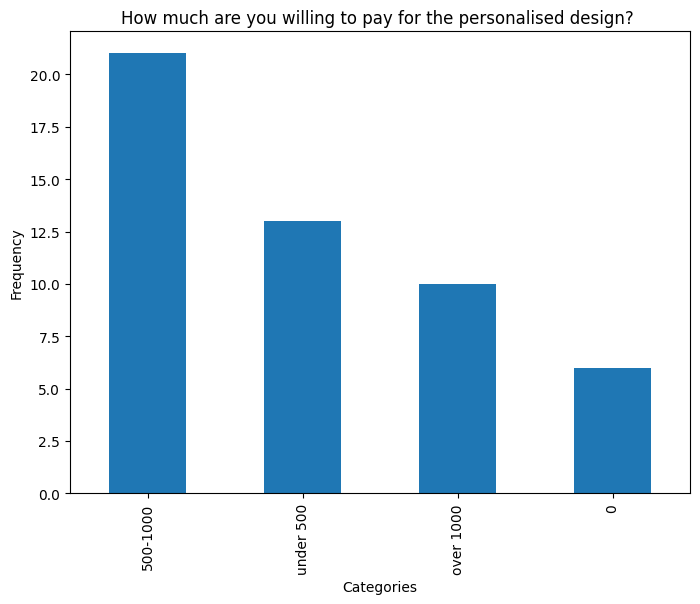

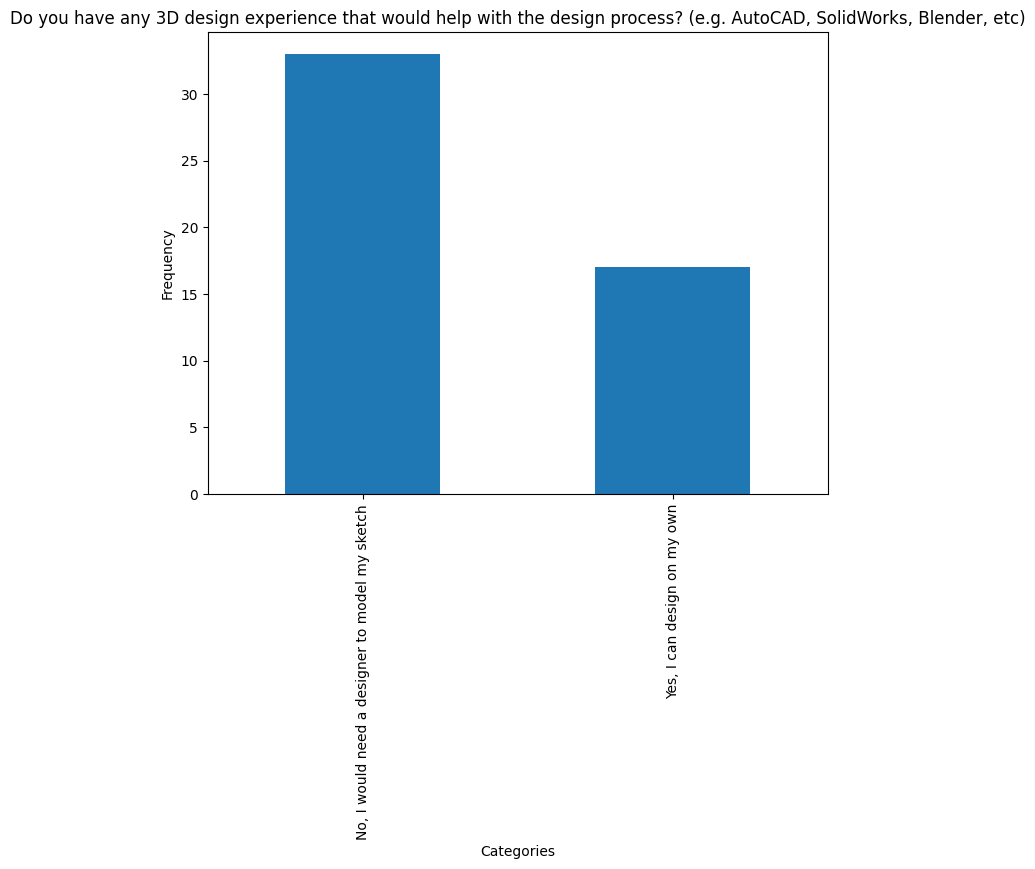

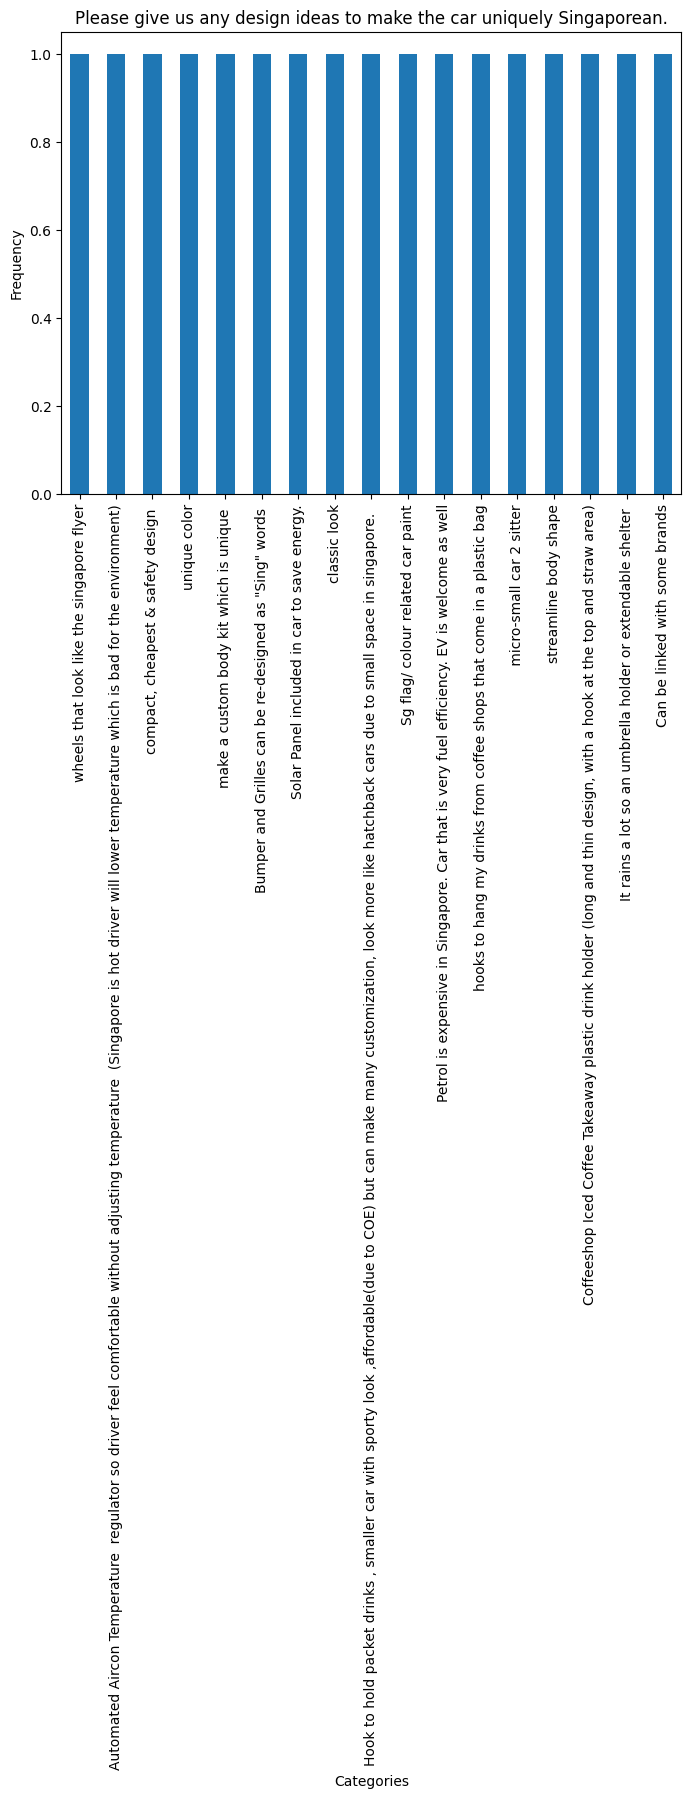

In [63]:
for column_name in data_raw_df.columns:
# Check if the column is numerical
    if data_raw_df[column_name].dtype in ['int64', 'float64']:
        # Plot histogram for numerical columns
        plt.figure(figsize=(8, 6))
        data_raw_df[column_name].hist(bins=20)  # Adjust bins as needed
        plt.title(f'{column_name}')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Plot bar plot for categorical columns
        plt.figure(figsize=(8, 6))
        data_raw_df[column_name].value_counts().plot(kind='bar')
        plt.title(f'{column_name}')
        plt.xlabel('Categories')
        plt.ylabel('Frequency')
        plt.show()

In [64]:
# Data Cleaning



In [65]:

# To change the keys (column names) of multiple columns:
data_mod_df = data_raw_df.copy()
data_mod_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership_status",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customsied_vehicle_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components_customisation",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components_customisation",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customisation_spend",
                            "Are you interested in designing your own components to personalise your car? ": "customisation_interest",
                            "How much are you willing to pay for the personalised design? ": "personalised_design_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "3D_design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)
data_mod_df.head()


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN
1,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Likely,Wheels;Grilles;Headlights;Side mirrors,Centre compartment,under 500,Only with professional help,under 500,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
2,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Aesthetics;Functionality;Customisable options,Very likely,Wheels;Grilles;Headlights;Side mirrors,Steering wheel;Dashboard,500-1000,Yes,500-1000,"Yes, I can design on my own",NaN
3,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels;Grilles;Headlights;Side mirrors;Bumpers,Steering wheel;Centre compartment;Door handles...,under 500,Yes,under 500,"No, I would need a designer to model my sketch",NaN
4,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels;Grilles;Headlights;Bumpers,Steering wheel;Centre compartment,over 1000,Only with professional help,over 1000,"No, I would need a designer to model my sketch",Sg flag/ colour related car paint


In [66]:
# print(data_mod_df["purchase_factors"][1])
# data_mod_df.loc[1, "purchase_factors"] = 1
# print(data_mod_df["purchase_factors"][1])

In [67]:
print('stop')

stop


In [68]:
def find_unique_values(df, column_name, delmiter):
    unique_values = []
    for values in df[column_name].unique():
        if values is np.nan:
            continue
        _ = values.split(delmiter)
        for value in _:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values

In [69]:
purchase_factors_unique = find_unique_values(data_mod_df, "purchase_factors", ";")
for factor in purchase_factors_unique:
  data_mod_df[factor] = data_mod_df["purchase_factors"].str.contains(factor)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,...,3D_design_experience,design_ideas,Price,Functionality,Size,Customisable options,Brand name,Aesthetics,Technological features,Sustainability/environment considerations
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,...,"No, I would need a designer to model my sketch",NaN,True,True,True,True,False,False,False,False


In [70]:
exterior_components_unique = find_unique_values(data_mod_df, "exterior_components_customisation", ";")
for components in exterior_components_unique:
  data_mod_df[components] = data_mod_df["exterior_components_customisation"].str.contains(components)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,...,Technological features,Sustainability/environment considerations,Grilles,Wheels,Headlights,Side mirrors,Bumpers,Brakes,doors,add body kit and change the exhaust and tune the engine
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,...,False,False,True,False,False,False,False,False,False,False


In [71]:
interior_components_unique = find_unique_values(data_mod_df, "interior_components_customisation", ";")
for components in interior_components_unique:
  data_mod_df[components] = data_mod_df["interior_components_customisation"].str.contains(components)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,...,Bumpers,Brakes,doors,add body kit and change the exhaust and tune the engine,Centre compartment,Steering wheel,Dashboard,Door handles,Sun blocker for front passengers,air vent
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,...,False,False,False,False,True,False,False,False,False,False


In [72]:
# from fuzzywuzzy import fuzz

# Define a function to calculate fuzzy match score
# def fuzzy_match_score(str1, str2):
# return fuzz.ratio(str1, str2)

# Apply fuzzy match score on a column of the dataframe
# new_df = data_raw_df.copy()
# new_df['Fuzzy Score'] = data_raw_df['How likely are you to opt for customised vehicle if there were no extra charges?'].apply(lambda x: fuzzy_match_score(x, 'Target_String'))


In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# categorical variables processed into numerical format 
data_raw_processed = pd.get_dummies(data_raw_df)
print(data_raw_processed.head())

# Assuming data_raw_df is your DataFrame with missing values

# Impute missing values in categorical variables using the most frequent category (mode)
imputer_categorical = SimpleImputer(strategy='most_frequent')
data_categorical_imputed = imputer_categorical.fit_transform(data_raw_df)
# Scale features : 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_raw_processed)

# PCA analysis : 

pca = PCA(n_components=50)
principal_components = pca.fit_transform(data_scaled)

# pca = PCA(n_components=2)  # Specify the number of principal components
# principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame to store the principal components
column_names = [f'PC{i+1}' for i in range(principal_components.shape[1])]
principal_df = pd.DataFrame(data=principal_components, columns=column_names)

# Display the DataFrame with principal components
print(principal_df.tail())

   Which age group do you belong to?_20-30  \
0                                     True   
1                                     True   
2                                     True   
3                                     True   
4                                     True   

   Which age group do you belong to?_31-40  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   Which age group do you belong to?_41-50  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   Which age group do you belong to?_51-60  What is your gender?_Female  \
0                                    False                        False   
1                  

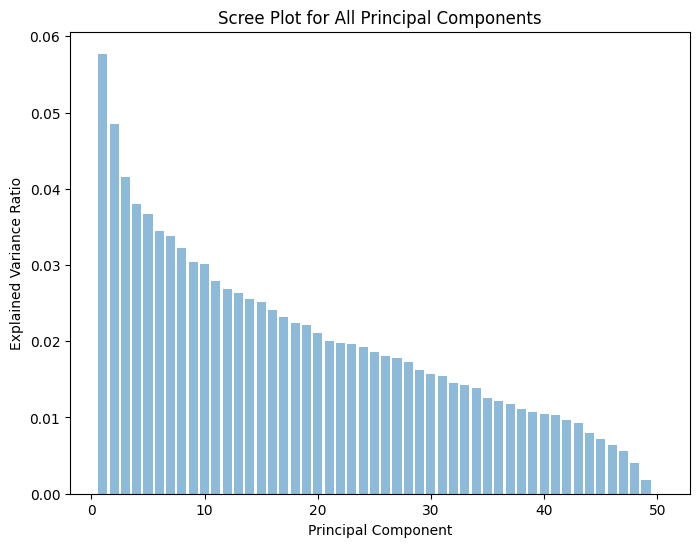

In [83]:
# Get the explained variance ratio from the PCA object
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot for the first 10 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for All Principal Components')
plt.show()

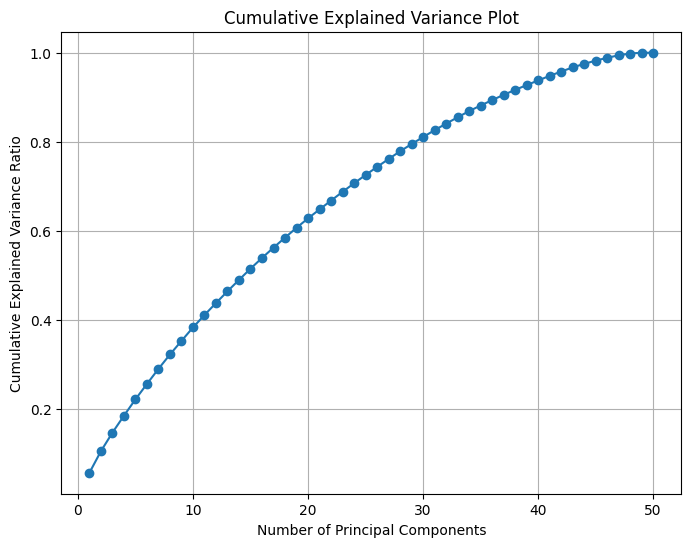

Number of principal components to retain: 24


In [84]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()

# Determine the number of principal components to retain based on the scree plot
threshold = 0.7  # Set the threshold for cumulative explained variance
num_components_retained = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f'Number of principal components to retain: {num_components_retained}')

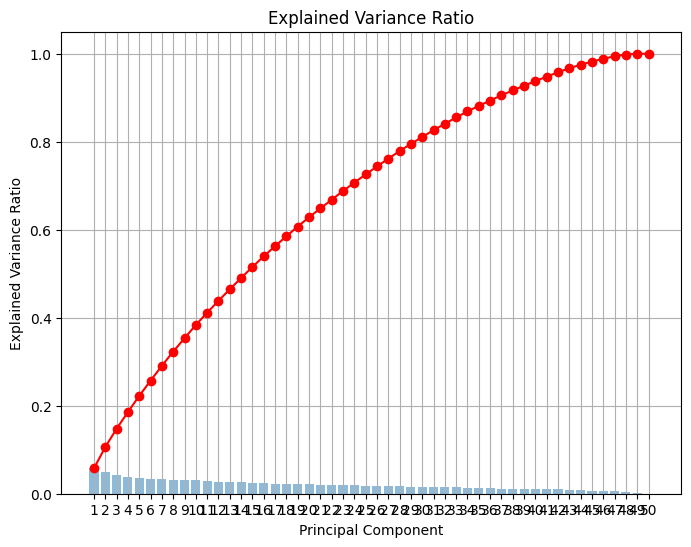

In [85]:
# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), color='red', marker='o', linestyle='-')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

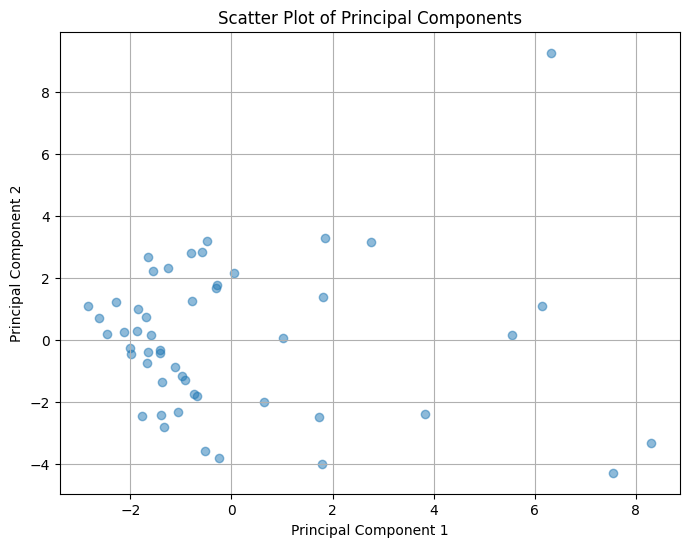

In [88]:
# Scatter plot of principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'], alpha=0.5)
plt.title('Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

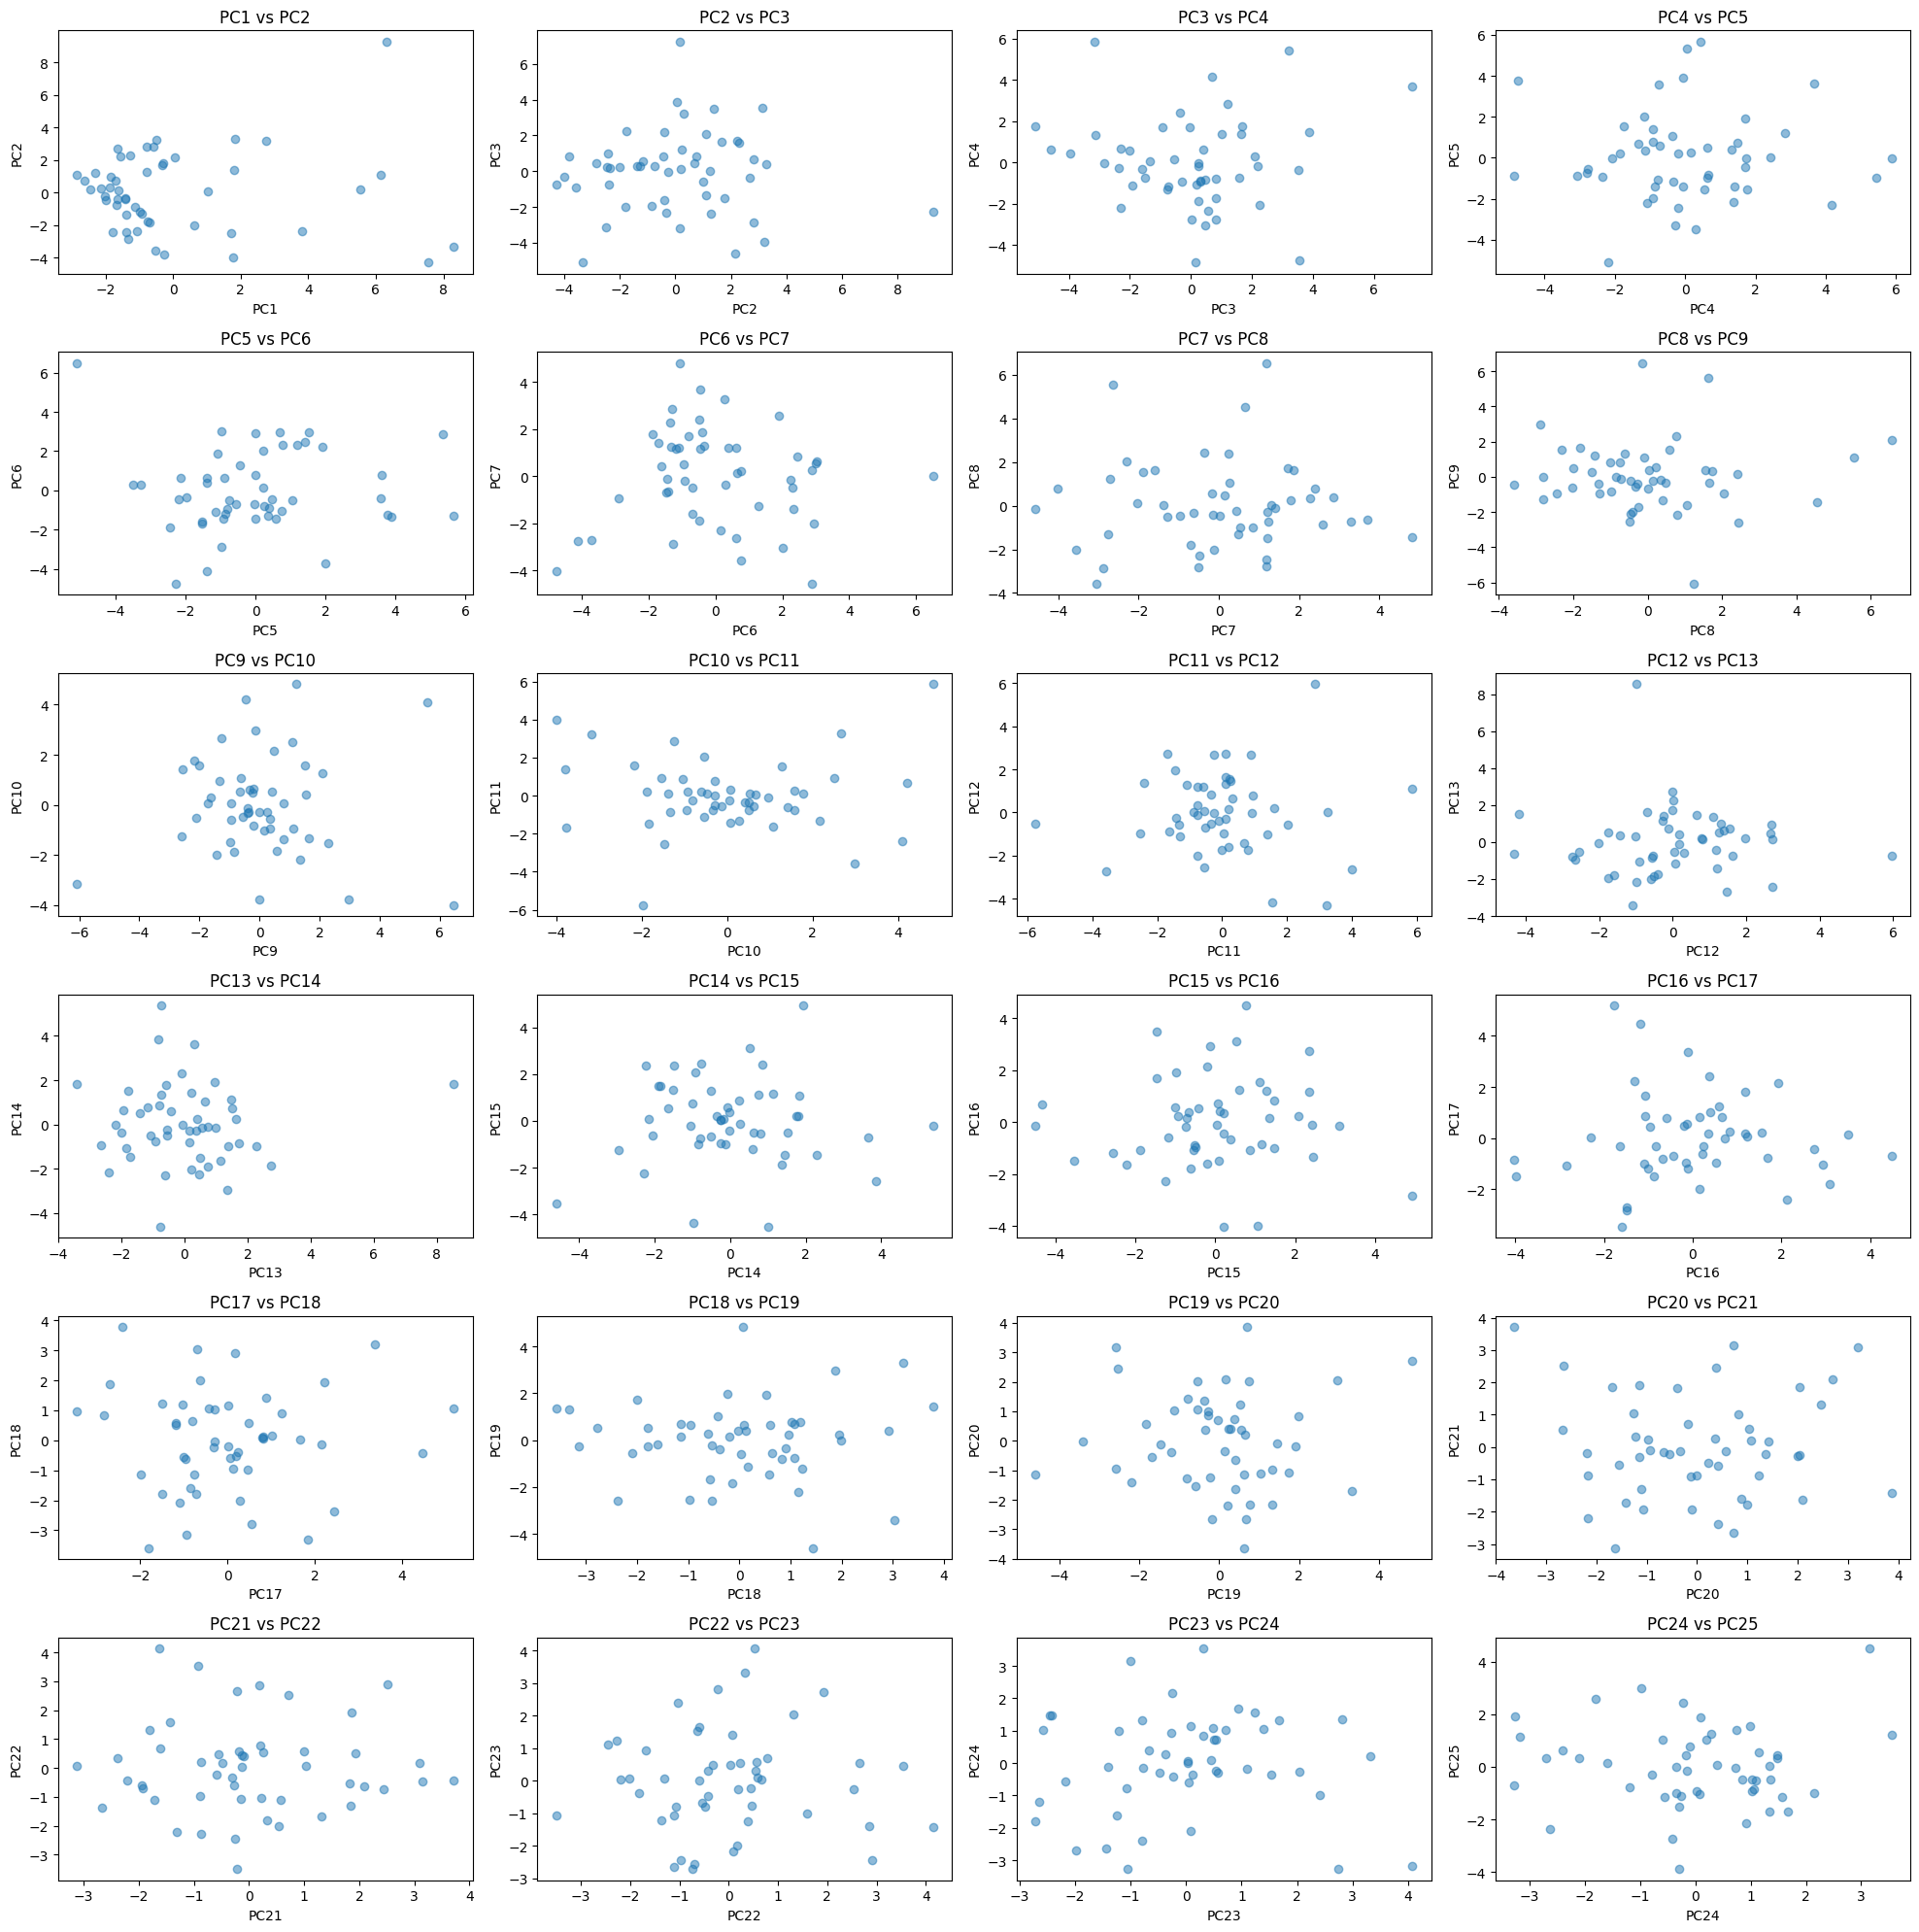

In [90]:
import itertools

# Define the number of principal components to visualize
num_components = 24

# Create a list of all combinations of two principal components
component_combinations = list(itertools.combinations(range(1, num_components + 1), 2))

# Plot scatter plots for each combination of principal components
plt.figure(figsize=(20, 20))
for i in range(24):
    plt.subplot(6, 4, i + 1)  # Adjusting the indexing to start from 1
    plt.scatter(principal_df[f'PC{i+1}'], principal_df[f'PC{i+2}'], alpha=0.5)  # Adjusted indices for PC
    plt.title(f'PC{i+1} vs PC{i+2}')
    plt.xlabel(f'PC{i+1}')
    plt.ylabel(f'PC{i+2}')
plt.tight_layout()
plt.show()

In [91]:
# creating a new feature space with reduced dimensions

new_feature = pd.concat([principal_df[f'PC{i}'] for i in range(1, 25)], axis=1)

# Print the shape of the new feature
print("Shape of new feature:", new_feature.shape)

Shape of new feature: (50, 24)


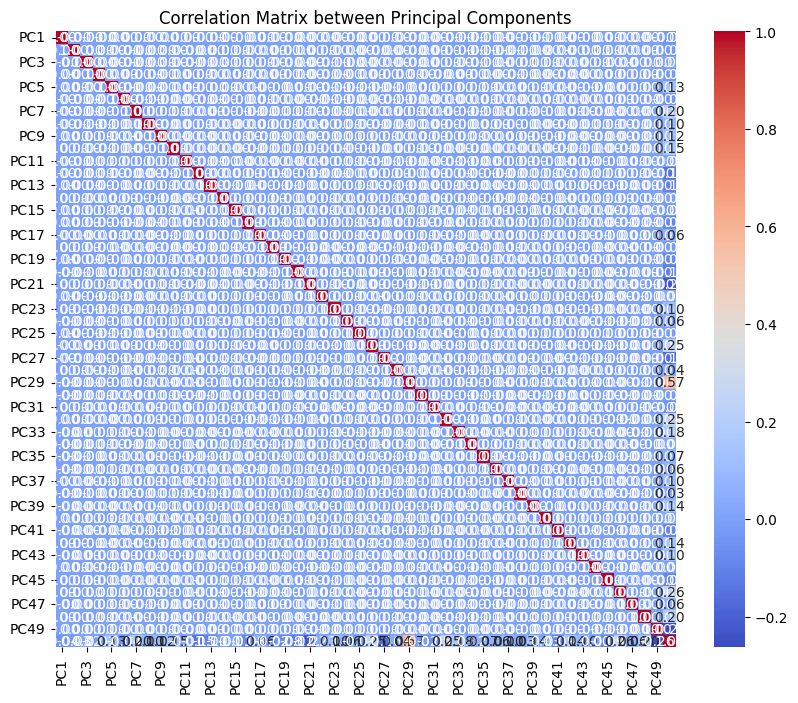

In [92]:
# Correlation analysis using pairwise set 

correlation_matrix = principal_df.corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Principal Components')
plt.show()